In [2]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
import pandas as pd
import numpy as np

[nltk_data] Downloading package punkt to /Users/antolifer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antolifer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antolifer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/antolifer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Get Data from the Dataset

In [47]:
with open('./datasets/business_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_businesses = pd.read_json(data_json_str)
    df_businesses['business_id'] = 'biz_' + df_businesses['business_id']
    
with open('./datasets/user_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_users = pd.read_json(data_json_str)

with open('./datasets/review_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews = pd.read_json(data_json_str)
    df_reviews['review_id'] = 'rev_' + df_reviews['review_id']
    df_reviews['business_id'] = 'biz_' + df_reviews['business_id']

/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_76036/2831228285.py:5: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_businesses = pd.read_json(data_json_str)
/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_76036/2831228285.py:12: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_users = pd.read_json(data_json_str)
/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_76036/2831228285.py:18: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_reviews = pd.read_json(data_json_str)


### Tokenize the Reviews

In [24]:
## iterate through each review and tokenize each review
for index, row in df_reviews.iterrows():
    review = row['text']
    tokens = word_tokenize(review)
    # remove punctuation
    words = [word for word in tokens if word.isalpha()]
    # remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    # stemming
    porter = PorterStemmer()
    words = [porter.stem(word) for word in words]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    df_reviews.at[index, 'text'] = ' '.join(words)

## create a new dataframe with the tokenized reviews
df_reviews_tokenized = df_reviews[['review_id', 'text', 'date']]
df_reviews_tokenized.to_json('./datasets/review_dataset_new_orleans_tokenized.json', orient='records', lines=True)


### Sentiment Analysis

In [25]:
import json
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Create Get Sentiment Function
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

# Load Tokenized Reviews
with open('./datasets/review_dataset_new_orleans_tokenized.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews_tokenized = pd.read_json(data_json_str)

# Get Sentiment for Each Review
df_reviews_tokenized['sentiment'] = df_reviews_tokenized['text'].apply(get_sentiment)

# Print Sentiment Distribution
print(df_reviews_tokenized['sentiment'].value_counts())
    

/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_76036/2294914106.py:17: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_reviews_tokenized = pd.read_json(data_json_str)


sentiment
1    608110
0     27254
Name: count, dtype: int64


In [26]:
# Save Sentiment to JSON
df_reviews_tokenized[['review_id', 'sentiment', 'date']].to_json('./datasets/review_dataset_new_orleans_sentiment.json', orient='records', lines=True)

# Load Sentiment
with open('./datasets/review_dataset_new_orleans_sentiment.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews_sentiment = pd.read_json(data_json_str)

/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_76036/4266901064.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_reviews_sentiment = pd.read_json(data_json_str)


/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_61390/2401048095.py:6: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_reviews_tokenized = pd.read_json(data_json_str)
/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_61390/2401048095.py:12: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_reviews_sentiment = pd.read_json(data_json_str)


Average Sentiment: 
0.9571049036457842
Average Sentiment for 2005: 0.9140893470790378 in 291 reviews
Average Sentiment for 2006: 0.9563758389261745 in 298 reviews
Average Sentiment for 2007: 0.9667477696674777 in 1233 reviews
Average Sentiment for 2008: 0.9714912280701754 in 3192 reviews
Average Sentiment for 2009: 0.9750037196845708 in 6721 reviews
Average Sentiment for 2010: 0.9701766784452297 in 14150 reviews
Average Sentiment for 2011: 0.9687760515346723 in 26390 reviews
Average Sentiment for 2012: 0.9657475002594886 in 28903 reviews
Average Sentiment for 2013: 0.9634908136482939 in 38100 reviews
Average Sentiment for 2014: 0.9605638759629297 in 51146 reviews
Average Sentiment for 2015: 0.9592598142043752 in 66740 reviews
Average Sentiment for 2016: 0.9566736646330295 in 70973 reviews
Average Sentiment for 2017: 0.9542985022311499 in 74177 reviews
Average Sentiment for 2018: 0.9544710490963073 in 88581 reviews
Average Sentiment for 2019: 0.9545369064409968 in 85080 reviews
Average 

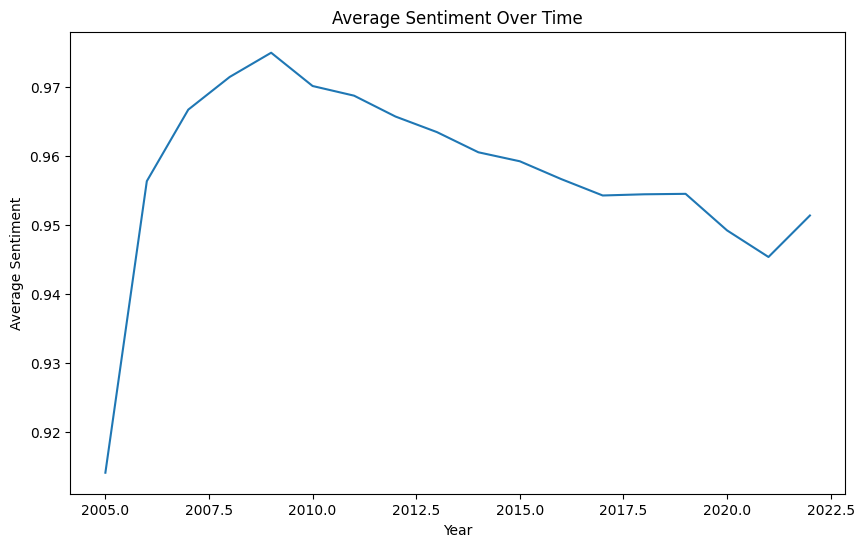

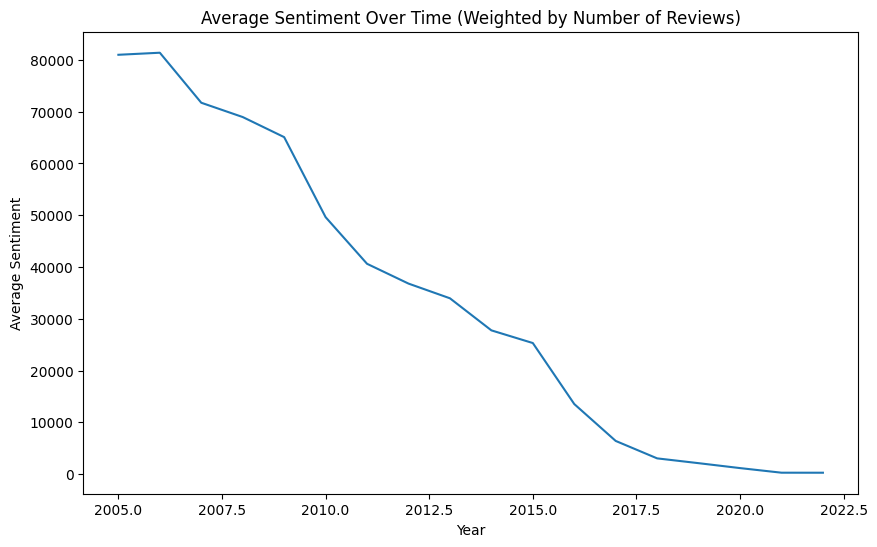

In [9]:
# Load Tokenized Reviews and Sentiment
with open('./datasets/review_dataset_new_orleans_tokenized.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews_tokenized = pd.read_json(data_json_str)

with open('./datasets/review_dataset_new_orleans_sentiment.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews_sentiment = pd.read_json(data_json_str)


# Obtain the average sentiment in general
avg_sentiment = df_reviews_sentiment['sentiment'].mean()
print("Average Sentiment: ")
print(avg_sentiment)

# Obtain the average sentiment for each year
df_reviews_sentiment['date'] = pd.to_datetime(df_reviews_sentiment['date'])
df_reviews_sentiment['year'] = df_reviews_sentiment['date'].dt.year
# Get total number of reviews by year
total_reviews_year = df_reviews_sentiment['year'].value_counts()
avg_sentiment_year = df_reviews_sentiment.groupby('year')['sentiment'].mean()

for year, sentiment in avg_sentiment_year.items():
    print(f"Average Sentiment for {year}: {sentiment} in {total_reviews_year[year]} reviews")


# Obtain the top 10 most common words/tokens in positive reviews
# Merge the tokenized reviews with the sentiment
df_reviews_tokenized = df_reviews_tokenized.merge(df_reviews_sentiment, on='review_id')

# Filter out the positive reviews
df_reviews_positive = df_reviews_tokenized[df_reviews_tokenized['sentiment'] == 1]

# Get the most common words in positive reviews
from collections import Counter
words = ' '.join(df_reviews_positive['text']).split()
word_freq = Counter(words)
top_words = word_freq.most_common(10)
print("Top 10 Most Common Words in Positive Reviews: ")
print(top_words)

# Obtain the top 10 most common words/tokens in negative reviews
# Filter out the negative reviews
df_reviews_negative = df_reviews_tokenized[df_reviews_tokenized['sentiment'] == 0]

# Get the most common words in negative reviews
words = ' '.join(df_reviews_negative['text']).split()
word_freq = Counter(words)
top_words = word_freq.most_common(10)
print("Top 10 Most Common Words in Negative Reviews: ")
print(top_words)

# Plot the average sentiment over time, taking into account the number of reviews
import matplotlib.pyplot as plt
import seaborn as sns

# Get total number of reviews by year
total_reviews_year = df_reviews_sentiment['year'].value_counts()
avg_sentiment_year = df_reviews_sentiment.groupby('year')['sentiment'].mean()

# Plot the average sentiment over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_sentiment_year.index, y=avg_sentiment_year.values)
plt.title('Average Sentiment Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment')
plt.show()

# Plot the average sentiment over time, taking into account the number of reviews
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_sentiment_year.index, y=avg_sentiment_year.values * total_reviews_year)
plt.title('Average Sentiment Over Time (Weighted by Number of Reviews)')
plt.xlabel('Year')
plt.ylabel('Average Sentiment')
plt.show()


From these analysis, we can take the following conclusions:

### Average Sentiment Analysis

The average sentiment score across all reviews is, approximately 0.957, which indicates a generally positive sentiment in the reviews. When analyzing each year more closely, we can see that the sentiment has been constantly high, hitting its peak around 2009. The lowest sentiment was in 2021, which could be reflect the pandemic that was present during this period. However, in 2022, there was a slight increase.

### Common Words in Reviews

When talking about positive reviews, the common words in these reviews are either really general (like "I", "the" or "food") or very positive (like "good" and "great" as standouts). This suggests that this type of reviews focus mainly on food and the user's dining experience.

Regarding the negative reviews, besides the common words identified above, the words "service", "order" and "time" are three words that are highlighted, which suggests that negative feedback often related to issues with the service, wait times or problems with a user's order.

### Graphs

The first graph showcases the Average Sentiment over Time, as it showcases the results in the "Average Sentiment Analysis" section. The second graph, however, is more interesting, as it takes into account the volume of reviews in each year. From it, we can see a huge decline since 2007, which highlights the importance of considering the number of reviews in this type of analysis, since a large number of user feedbacks can dilute the sentiment score.

